# 6 features
# features: pitch, start, end, duration, velocity, instrument.program 

# Finall Code

# Preprocessing and feature engineering

# Load the .pkl file

# Cell 3 — Load pkl, preprocess, train, evaluate, save

B Two‑input model with a small program embedding (+ mild attention)




In [ ]:
# --- Cell 2: Load pkl, preprocess, build & train model ---
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Concatenate, Masking, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1) Load saved balanced dataset
with open("../models/RNN/balanced_chunks_seq70_minorthings.pkl", "rb") as f:
    balanced_dataset = pickle.load(f)

# 2) Separate features & labels
X_notes = []
X_prog = []
y = []

for chunk, label in balanced_dataset:
    X_notes.append(chunk[:, [0, 1, 2, 3, 4]])  # dt, interval, pc, dur_ratio, velocity
    X_prog.append(chunk[:, 5].astype(int))     # program column
    y.append(label)

X_notes = np.array(X_notes, dtype=np.float32)  # shape: (n_samples, 70, 5)
X_prog = np.array(X_prog, dtype=np.int32)      # shape: (n_samples, 70)
y = np.array(y)

# 3) Scale numeric note features
scaler = StandardScaler()
nsamples, ntimesteps, nfeatures = X_notes.shape
X_notes_2d = X_notes.reshape(-1, nfeatures)
X_notes_2d[:, :5] = scaler.fit_transform(X_notes_2d[:, :5])
X_notes = X_notes_2d.reshape(nsamples, ntimesteps, nfeatures)

# 4) Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 5) Train/test split
Xn_train, Xn_test, Xp_train, Xp_test, y_train, y_test = train_test_split(
    X_notes, X_prog, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 6) Build model
note_in = Input(shape=(70, 5), name="notes")
prog_in = Input(shape=(70,), dtype="int32", name="programs")
prog_emb = Embedding(input_dim=129, output_dim=10, mask_zero=True)(prog_in)
x = Concatenate(axis=-1)([note_in, prog_emb])
x = Masking(mask_value=0.0)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.25)(x)
x = LSTM(96)(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
out = Dense(len(le.classes_), activation='softmax')(x)

model = Model([note_in, prog_in], out)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# 7) Class weights
cw = {i: 1.0 for i in range(len(le.classes_))}
cw[int(np.where(le.classes_=="Beethoven")[0][0])] = 1.4
cw[int(np.where(le.classes_=="Mozart")[0][0])]    = 1.2

# 8) Callbacks
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ckpt  = ModelCheckpoint('seq70_noMHA_b96.keras', monitor='val_loss', save_best_only=True)
rlr   = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# 9) Train
history = model.fit(
    [Xn_train, Xp_train], y_train,
    validation_data=([Xn_test, Xp_test], y_test),
    epochs=100, batch_size=64,
    callbacks=[early, ckpt, rlr],
    class_weight=cw, verbose=1
)

# 10) Save final model
model.save("balanced_chunks_seq70_final.keras")


Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.4169 - loss: 1.4069 - val_accuracy: 0.5766 - val_loss: 0.9519 - learning_rate: 0.0010
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5577 - loss: 1.1151 - val_accuracy: 0.5746 - val_loss: 0.9412 - learning_rate: 0.0010
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.5993 - loss: 1.0374 - val_accuracy: 0.5643 - val_loss: 0.9578 - learning_rate: 0.0010
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.6063 - loss: 1.0092 - val_accuracy: 0.6332 - val_loss: 0.8262 - learning_rate: 0.0010
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.6407 - loss: 0.9474 - val_accuracy: 0.6416 - val_loss: 0.7815 - learning_rate: 0.0010
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6544 - loss: 0.9092 - val_accuracy: 0.6327 - val_loss: 0.7978 - learning_rate: 0.0010
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.6719

# Evaluation

Test Accuracy: 0.8183
Test Loss: 0.4749
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Classification Report:
              precision    recall  f1-score   support

        Bach       0.91      0.93      0.92       508
   Beethoven       0.70      0.75      0.73       507
      Chopin       0.85      0.85      0.85       508
      Mozart       0.82      0.74      0.78       508

    accuracy                           0.82      2031
   macro avg       0.82      0.82      0.82      2031
weighted avg       0.82      0.82      0.82      2031



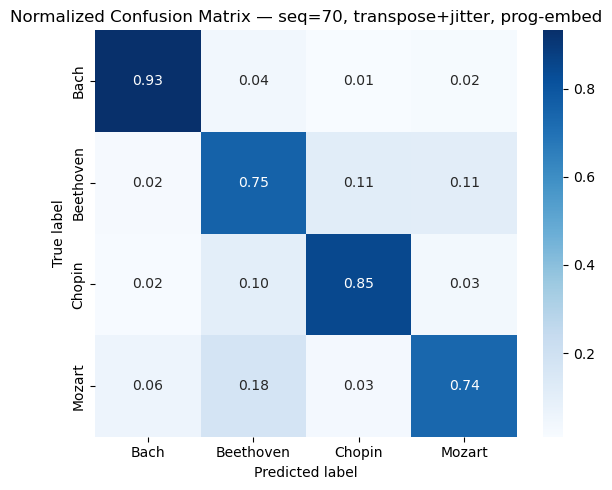

In [53]:
# --- Cell 3: Evaluate & Plot Confusion Matrix ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf

# If loading a saved model instead of using the one just trained:
# model = tf.keras.models.load_model("final_seq70_model.keras")

# Evaluate
loss, acc = model.evaluate([Xn_test, Xp_test], y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predictions
y_pred_probs = model.predict([Xn_test, Xp_test])
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Normalized Confusion Matrix — seq=70, transpose+jitter, prog-embed")
plt.tight_layout()
plt.show()
